In [117]:
#This code produces a plot to solve Homework 3 assigned by Carl Brune to the TALENT Nuclear Reaction Theory
#Summer School in 2019
#Author:  Chad Ummel

import math
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mm

In [118]:
#Physical constants
hbar = 197.3269 #(hbar*c in MeV fm)
alpha = 1/137.035999679 #Fine structure constant

In [119]:
#Particle info

#Channel d = d+t ->Index 0
#Channel a = a+n ->Index 1

#Masses (in MeV)
mp = [2.013553212745*931.5,939.565] #projectile mass [m_d,m_n]
mt = [3.0160492*931.5,3727.79378] #target mass [m_t,m_a]
mu = np.multiply(mp,mt)/np.add(mp,mt)

#Charges
Zp = [1,0] #projectile charges [Z_d,Z_n]
Zt = [1,2] #target charges [Z_t,Z-a]

#Spins
Jp = [1,0.5] #Projectile Spins [J_d,J_n]
Jt = [0.5,0] #Target spins [J_t,J_a]

#Threshold Energies (in MeV)
Q=[0,17.589293]

In [143]:
#Constants defined by problem
ac = [5.0,3.0]
B = [-0.27864,-0.557]
l=[0,2]
gamma=[[0.95838,0.48304],[0.27781,1.51753]] #[[gamma_d_0,gamma_d_1],[gamma_a_0,gamma_a,1]
ER = [0.021626,10.0]
J = 1.5

In [121]:
#Coulomb subroutine
def coulomb(l,k,ac,eta):
    rhoc = np.multiply(k,ac)
    F = lambda rho: mm.coulombf(l,eta,rho)
    G = lambda rho: mm.coulombg(l,eta,rho)
    Fprime = lambda rho: mm.diff(F,rho)
    Gprime = lambda rho: mm.diff(G,rho)
    Fc = float(F(rhoc))
    Gc = float(G(rhoc))
    Fcprime = float(Fprime(rhoc))
    Gcprime = float(Gprime(rhoc))
    Ac = math.sqrt(Fc*Fc + Gc*Gc)
    Acprime = (Fc*Fcprime + Gc*Gcprime)/math.sqrt(Fc*Fc + Gc*Gc)
    return(rhoc,Ac,Acprime)

In [122]:
#Whittaker subroutine
def whittaker(l,kappa,ac,etaneg):
    rhoc = 2*kappa*ac
    W = lambda rho: mm.whitm(etaneg,l+0.5,rho)
    Wprime = lambda rho: mm.diff(W,rho)
    Wc = float(W(rhoc))
    Wcprime = float(Wprime(rhoc))
    return(rhoc,Wc,Wcprime)

In [128]:
#Penetration subroutine
def penetration(ECM,ac,l,k,eta):
    if ECM < 0:
        P = 0.0
    else:
        (rhoc,Ac,Acprime)=coulomb(l,k,ac,eta)
        P = rhoc/Ac
        return(P)

In [129]:
#Shift subroutine
def shift(ECM,ac,l,k,kappa,eta,etaneg):
    if ECM < 0:
        (rhoc,Wc,Wcprime)=whittaker(l,kappa,ac,etaneg)
        Sc = rhoc/Wc*Wcprime
    else:
        (rhoc,Ac,Acprime)=coulomb(l,k,ac,eta)
        Sc = rhoc*Acprime/Ac
        return(Sc)

In [273]:
#R-matrix subroutine
def Rmatrix(E):
    
    E = E/1000 #Convert to MeV
    ECM = [0,0]
    ECM[0] = E*mt[0]/(mp[0]+mt[0])
    ECM[1] = E*mt[1]/(mp[1]+mt[1])

    #Calculate g-factors
    g = [0,0]
    g[0] = (2*J+1)/((2*Jp[0]+1)*(2*Jt[0]+1))
    g[1] = (2*J+1)/((2*Jp[1]+1)*(2*Jt[0]+1))

    #Calculate Excitation Energies
    Ex = [0,0]
    Ex[0] = ECM[0]
    Ex[1] = ECM[0]-Q[0]+Q[1]
    
    kpre = np.sqrt(2*mu)/hbar
    k = kpre*np.sqrt(Ex)
    kappa = kpre*np.sqrt(np.subtract(0,Ex))
    etapre = alpha*np.multiply(Zp,Zt)*np.sqrt(mu/2);
    eta = etapre/np.sqrt(Ex)
    etaneg = -1*etapre/np.sqrt(np.subtract(0,Ex))
    
    #Calculate the R-matrix boi
    L=[0,0]
    R = [[0,0],[0,0]]
    R1 = [[0,0],[0,0]]
    P = [0,0]
    Sc = [0,0]
    P[0]=penetration(Ex[0],ac[0],l[0],k[0],eta[0])
    P[1]=penetration(Ex[1],ac[1],l[1],k[1],eta[1])
    Sc[0] =shift(Ex[0],ac[0],l[0],k[0],kappa[0],eta[0],etaneg[0])
    Sc[1] =shift(Ex[1],ac[1],l[1],k[1],kappa[1],eta[1],etaneg[1])
    for i in range(0,2,1):
        for j in range(0,2,1):
            for level in range(0,2,1):
                R[i][j] = R[i][j] + gamma[i][level]*gamma[j][level]/(ER[level]-Ex[0])
            L[j] = complex(Sc[j],P[j])
            R1[i][j] = R[i][j]*(B[j]-L[j])
            if i==j:
                R1[i][j] = R1[i][j] + 1
    
    RL = np.matmul(np.linalg.inv(R1),R)
    
    cs = math.pi/(k[0]*k[0])*g[0]*4*P[0]*P[1]*abs(RL[0][1]*RL[0][1])*0.01
    S = cs*ECM[0]*math.exp(2*math.pi*eta[0])
        
    return(cs,S)

In [274]:
E = np.linspace(1,140,14)
cs = np.zeros(len(E))
S = np.zeros(len(E))
for i in range(0,len(E),1):
    (cs[i],S[i])=Rmatrix(E[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


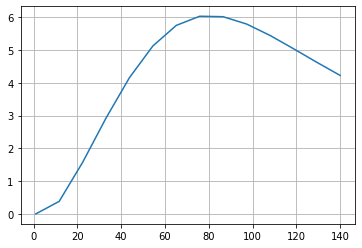

In [275]:
plt.plot(E,cs)
plt.grid()

(0, 1000)

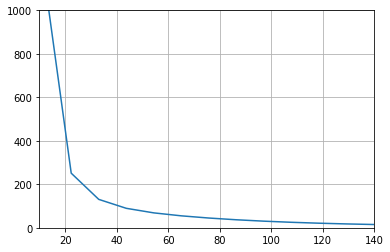

In [277]:
#Something is up with S because it looks awful
plt.plot(E,S)
plt.grid()
plt.xlim(10,140)
plt.ylim(0,1000)